# Data Mining Cup 2016
## Considerations
### Language Choice
We didn't want to use visual tools like IBM SPS Modeller or KNIME as we don't have the necessary control over the dataprocessing. This leaves Python and R. Because we haven't done anything in R and it has a steep learning curve, we choose Python.

### Imports

In [9]:
import pandas as pd
import matplotlib
import holidays
import seaborn
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set()

## Data
### Import Data

In [18]:
data_train = pd.read_csv('orders_train.txt',sep = ';')

### Rough Data Analysis
Before we go to a deep data analysis, we check out rough characteristics of our data. First all numeric data which all need to be normalized.
For example we can see that orders with a quantity of 0 are possible. More on that later.
Also there are missing values, which have to be handled.

In [3]:
data_train.describe(percentiles=[]).fillna(0).transpose()

count         mean          std     min      50%      max
colorCode       2325165.0  2148.216467  1740.827036  1000.0  1493.00  8888.00
productGroup    2324814.0     5.958604     6.063121     1.0     3.00    90.00
quantity        2325165.0     0.995543     0.164028     0.0     1.00    24.00
price           2325165.0    35.399105    22.662477     0.0    29.99   623.76
rrp             2324814.0    42.985147    24.011038     0.0    39.99   799.99
voucherAmount   2325165.0     2.153040     6.537824     0.0     0.00   300.00
deviceID        2325165.0     2.462385     0.848023     1.0     2.00     5.00
returnQuantity  2325165.0     0.521408     0.503670     0.0     1.00     5.00

Next we look at categorical values. Here we use binary features as they tend to yield better results. There are relatively few different articles being bought. The same holds true for the different customers.

In [4]:
data_train.describe(percentiles=[], include=['O']).fillna('').transpose()

count  unique         top     freq
orderID        2325165  738698    a1602669       46
orderDate      2325165     638  2014-07-29     9957
articleID      2325165    3823    i1003278    26208
sizeCode       2325165      29          38   395163
voucherID      2325159     670           0  1868227
customerID     2325165  311369    c1070653     1256
paymentMethod  2325165      10        BPRG  1810036

### Target Variable
The returnQuantity attribute is to be predicted by the classifier. As can be seen in the plot below, a large number of the orders feature no returns or the return of 1 item. Therefore we consider the problem of predicting the return quantity as a classification problem. An additional reason for modeling the problem as classification is that the final prediction must be a natural number.

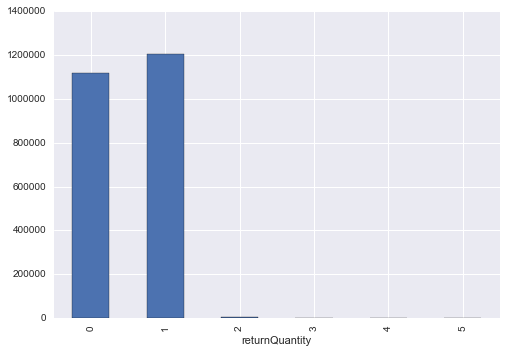

In [5]:
d = data_train.groupby('returnQuantity').size()
d.plot(kind='bar')

### Test Data
We check if all possible feature values from our training data is also in our test data.

In [11]:
data_test = pd.read_csv('orders_class.txt', sep = ';')

First we check if our theory of the assumed dummy article is compliant to the test data.
As we see it is.

In [12]:
data_test.isnull().sum() == data_test[data_test['articleID'] == "i1004001"].isnull().sum()

orderID          True
orderDate        True
articleID        True
colorCode        True
sizeCode         True
productGroup     True
quantity         True
price            True
rrp              True
voucherID        True
voucherAmount    True
customerID       True
deviceID         True
paymentMethod    True
dtype: bool

The test data contains 418 articles which are not in our training set. This is a relatively low number

In [19]:
len(np.setdiff1d(data_test['articleID'].unique(), data_train['articleID'].unique()))

418

In [14]:
len(np.setdiff1d(data_test['productGroup'].unique(), data_train['productGroup'].unique()))

14

There

In [15]:
len(np.setdiff1d(data_test['quantity'].unique(), data_train['quantity'].unique()))

0

In [20]:
len(np.setdiff1d(data_test['customerID'].unique(), data_train['customerID'].unique()))

30669

There are no new paymentMethods which is convenient for us.

In [17]:
len(np.setdiff1d(data_test['paymentMethod'].unique(), data_train['paymentMethod'].unique()))

0

### Data Abnomalies
#### N/A-Values
The article with the id "1004001" has almost all N/A-values. It seems to be a dummy product.
As there is just one voucherID with a different articleID, we do deal with missing values.

In [80]:
data_train.isnull().sum() - data_train[data_train['articleID'] == "i1004001"].isnull().sum()

orderID            0
orderDate          0
articleID          0
colorCode          0
sizeCode           0
productGroup       0
quantity           0
price              0
rrp                0
voucherID          1
voucherAmount      0
customerID         0
deviceID           0
paymentMethod      0
returnQuantity     0
price_rrp_ratio    0
dtype: int64

#### Quantity < returnQuantity
Another abnomaly is that some customer can return more from the same order than they ordered. This just happens with quantity 0 or 1.

In [61]:
data_train.groupby(['quantity', 'returnQuantity']).size()

quantity  returnQuantity
0         0                  25268
          1                      7
1         0                 861969
          1                 958369
          2                      1
2         0                   5819
          1                   4173
          2                   2916
3         0                    712
          1                    127
          2                     99
          3                    135
4         0                    192
          1                     23
          2                     15
          3                     15
          4                     20
5         0                    211
          1                     17
          2                      6
          3                      2
          4                      8
          5                     23
7         0                      1
9         0                      1
11        0                      1
15        0                      1
24        0                   

#### Quantity of 0
There are 31643 orders where nothing gets ordered. As there are so many instances of this, we think they are gifts and as that they are not excluded.

In [19]:
data_train[data_train['quantity'] == 0].count()[0]

31643

## Features
We define in the follow python methodes which take the data set and return features. In the next step the methodes will be used for feature set generation.

### Standart Features

#### productGroup
We also check the available productGroups which are in the test set to use all available knowledge.

In [21]:
def productGroup_feature(data):

    all_data = pd.concat([train_data, test_data])
    uniPG = all_data['productGroup'].unique()

    productGroupNP = np.zeros([data.shape[0],uniPG.shape[0]])
    names = []
    for u in np.arange(uniPG.shape[0]):
        productGroupNP[:,u] = data['productGroup'].isin([uniPG[u]])
        names.append("productGroup_" + str(uniPG[u]) )

    return productGroupNP, names

#### Quantity
The more one customer orders, the more propable it is, that something gets returned.

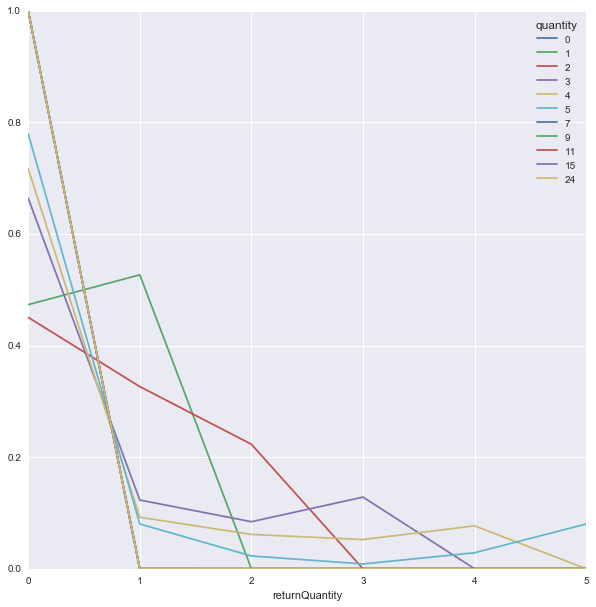

In [22]:
quantities = data_train.groupby('quantity').size()
d = data_train.groupby(['quantity', 'returnQuantity']).size()
d = d.unstack('quantity').fillna(0)
(d/quantities).plot(figsize=(10,10))

In [23]:
def feature_quantity(data):
    df = DataFrame()
    names = []

    for i in range(0,5):
        df[i] = np.asarray(data['quantity'] == i).astype(int)
        names.append("quantity_" + str(i))

    df[5] = np.asarray(data['quantity'] >= 5).astype(int)
    names.append("quantity_more_than_four")

    return np.asarray(df), names

#### Price
The higher the price is the higher the the propability of a returned package.

In [24]:
def feature_price(data):
    d = np.asarray(pd.to_numeric(data['price']) - np.mean(data['price']) )/ np.std(data['price'])
    return d, ["price"]

#### rrp (recommended retail price)
Again the feature on its own doesn't help but we will use it in combination with the price feature.

In [25]:
def feature_rrp(data):
    data['rrp'] = data['rrp'].fillna(data['price'])
    d = np.asarray((pd.to_numeric(data['rrp']) - np.mean(data['rrp'])) / np.std(data['rrp']))
    return d, ["rrp"]

#### VoucherAmount
The amount of the voucher can also be helpful in the prediction of the return quantity. In our classifier we use a normalized version of this feature. The new feature is calculated as follows:

In [26]:
def feature_voucher_amount(data):
    d = np.asarray(pd.to_numeric(data['voucherAmount']) - np.mean(data['voucherAmount'])) / np.std(data['voucherAmount'])
    return d, ["voucherAmount"]

#### deviceID
The device type is also an intersting feature for the classification. The main points that can be infered from the plot below are:
+ Items ordered from a device with ID 1 are significantly more likely to be returned than items ordered from other device types
+ The other device types are rather not that helpful in the prediction.

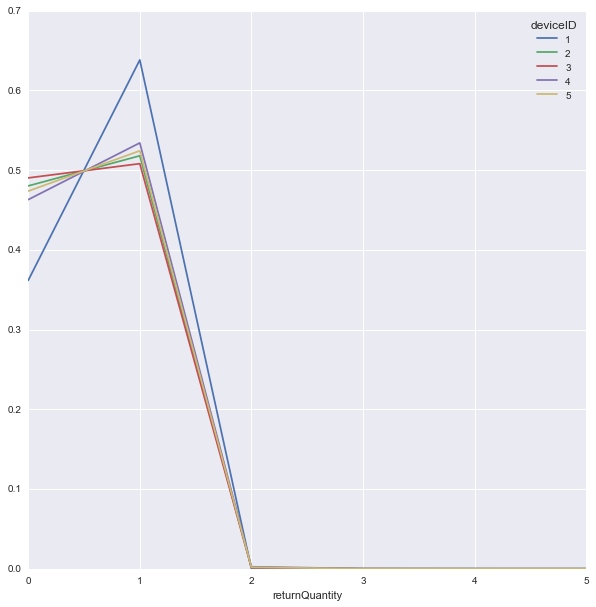

In [27]:
devices = data_train.groupby('deviceID').size()
d = data_train.groupby(['deviceID', 'returnQuantity']).size().unstack('deviceID').fillna(0)
(d/devices).plot(figsize=(10,10))

For our classifier, we have broken up this feature into 5 separate boolean features. Each one of these is true if the device used is has the corresponding ID. For example if a device has the ID 2, the corresponding feature vector is [0,1,0,0,0]. The features are calculated as follows:

In [28]:
def feature_deviceID(data):
    df = DataFrame()
    names = []

    for i in range(1,6):
        df[i] = np.asarray(data['deviceID'] == i).astype(int)
        names.append("deviceID_" + str(i))

    return np.asarray(df), names

#### paymentMethod
The payment method presents an interesting feature. Most of the payment methods have a significantly lower share of returned items. However, one of the most commonly used methods, BPRG, has a higher share on returned items. This can be also seen on the plot below: 

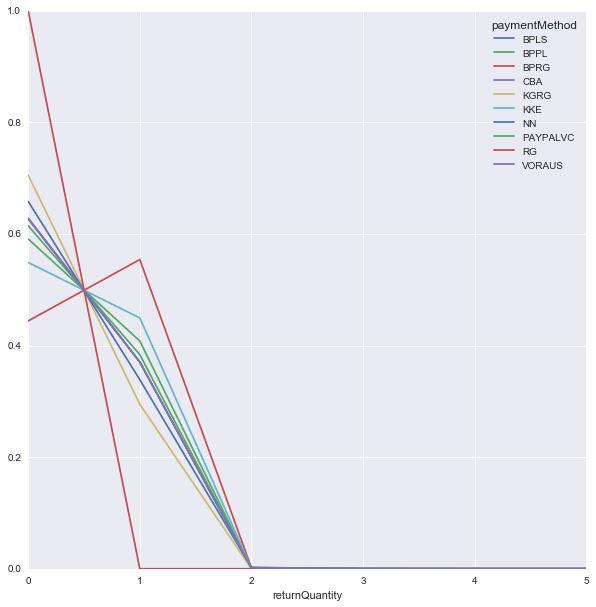

In [29]:
payments = data_train.groupby('paymentMethod').size()
d = data_train.groupby(['paymentMethod', 'returnQuantity']).size().unstack('paymentMethod').fillna(0)
(d/payments).plot(figsize=(10,10))

For our classifier, we have broken up this feature into separate boolean features for each payment type. Each one of these is true if the payment was made using the corresponding method. For example if an order was paid for using PayPal the boolean feature for PAYPALVC will have the value 1 and the boolean features for the rest of the payment methods will have the value 0. The features are calculated as follows:

In [30]:
def feature_paymentMethod(data):
    df = DataFrame()
    paymentMethods = data.paymentMethod.unique()
    names = []

    for i, method in enumerate(paymentMethods):
        df[i] = np.asarray(data['paymentMethod'] == method).astype(int)
        names.append('paymentMethod_' + str(i))

    return np.asarray(df), names

### Derived Features
#### BasketLength
The basket length is computed using orderID and shows how many articles a customer has bought at once.

In [31]:
def prepare_basket_length(data):
    orders = data.groupby('orderID').size()
    df = data.join(DataFrame(orders), on='orderID')
    baskets = df[0]
    baskets = (baskets-baskets.mean()) / baskets.std()

    d = np.ndarray(shape=(data.shape[0], 1))
    d[:,0]= baskets

    return d, ["basketLength"]

#### Price-RRP-Ratio
The lower the difference between the price and the rrp is, the better the deal was for the consumer.

In [32]:
def feature_price_rrp_ratio(data):
    data['price_rrp_ratio'] = np.max(data['price'] - data['rrp'], 0)
    d = pd.to_numeric(((data['price_rrp_ratio']) - np.mean(data['price_rrp_ratio'])) / np.std(data['price_rrp_ratio']))
    return d, ["price_rrp_ratio"]

#### VoucherUsed
Using the voucherAmount we check if a voucher was used.

In [33]:
def feature_voucher_used(data):
    d = np.asarray(data['voucherAmount'] > 0)
    return d, ["voucherUsed"]

#### frequentBuyer
We try to categorise all customers on basis how frequently the buy.

In [34]:
def feature_frequent_buyer(data):
    df = DataFrame()
    customerOrders = data.groupby('customerID').size()
    customerLabels = pd.qcut(customerOrders, [0, 0.5, 0.75, 1], labels=[0,1,2])
    df = data.join(DataFrame(customerLabels), on='customerID')

    d = np.asarray(pd.get_dummies(df[0])) #3 binary features for the 3 categories of buyers
    names = ["infrequent_buyer", "frequent_buyer", "excessive_buyer"]
    return d, names

#### week
There might be weeks where more clothes get returned

In [35]:
def feature_week(data):
    data['orderDate'] = pd.to_datetime(data['orderDate'], format='%Y-%m-%d')
    d = np.asarray((data['orderDate'].dt.week - np.mean(data['orderDate'].dt.week)) / np.std(data['orderDate'].dt.week))
    return d, ["week"]

#### month
This feature has the same idea behind it as week. We have to check which performs better

In [36]:
def feature_month(data):
    data['orderDate'] = pd.to_datetime(data['orderDate'], format='%Y-%m-%d')
    d = np.asarray((data['orderDate'].dt.month - np.mean(data['orderDate'].dt.month)) / np.std(data['orderDate'].dt.month))
    return d, ["month"]

#### holiday
We think that clothes which get bought on holidays might have higher return rates. We try it with German holidays as our best guess.

In [37]:
def feature_holiday(data):
    data['orderDate'] = pd.to_datetime(data['orderDate'], format='%Y-%m-%d')
    de_holidays = holidays.DE()
    d = np.asarray(data['orderDate'].dt.date.isin(de_holidays))
    return d, ["holiday"]

#### xmas
We think that after christmas the return rates are higher as people return gifts they didn't like.

In [38]:
def feature_xmas(data):
    data['orderDate'] = pd.to_datetime(data['orderDate'], format='%Y-%m-%d')
    d = np.asarray(data['orderDate'].dt.week > 46)
    return d, ["xmas"]

#### numPurchase
This feature describes how many articles the same customer already bought, as they might 

In [39]:
def feature_num_purchase(data):
    data['id'] = data.index
    temp_colums = np.zeros([data[[0]].__len__(), 2])
    sortedData = data.sort_values(['customerID', 'orderID'], ascending=[True, True])
    temp_colums[:, 0] = sortedData['id']
    for index, row in sortedData.iterrows():
        if var is not row['customerID']:
            var = row['customerID']
            date_old = row['orderDate']
            number = -1
        number += 1
        temp_colums[index, 1] = number

        date_old = row['orderDate']

    temp_colums[temp_colums[:, 0].argsort()]
    data['numPurchase'] = temp_colums[:, 1]
    d = np.asarray((data["numPurchase"] - np.mean(data["numPurchase"])) / np.std(data["numPurchase"]))

    return d, ["num_purchase"]

#### daysSinceLast
If the days since the last purchase is low, we think the return rate is higher as the customer tries some clothes and returns the rest

In [40]:
def feature_days_since_last(data):
    data['orderDate'] = pd.to_datetime(data['orderDate'], format='%Y-%m-%d')
    data['id'] = data.index
    temp_colums = np.zeros([data[[0]].__len__(), 2])
    sortedData = data.sort_values(['customerID', 'orderID'], ascending=[True, True])
    temp_colums[:, 0] = sortedData['id']
    for index, row in sortedData.iterrows():
        if var is not row['customerID']:
            var = row['customerID']
            date_old = row['orderDate']
        date_diff = row['orderDate'] - date_old
        temp_colums[index, 1] = date_diff
        date_old = row['orderDate']

    temp_colums[temp_colums[:, 0].argsort()]
    data['days_since_last'] = temp_colums[:, 1]
    d = np.asarray((data["days_since_last"] - np.mean(data["days_since_last"])) / np.std(data["days_since_last"]))

    return d, ["days_since_last"]


#### returnRatio
We calculate the return ratio per customer as it is a trait of a customer if one returns or doesn't.

In [41]:
def train_features_ReturnRatio(data):
    customer_rr = prepare_return_ratio_train(data, 'customerID')
    article_rr = prepare_return_ratio_train(data, 'articleID')
    features = np.concatenate([customer_rr, article_rr], axis=1).astype(float)
    return features, ['customerReturnRatio','articleReturnRatio']

def test_features_ReturnRatio(data):
    customer_rr = prepare_return_ratio_test(data, 'customerID')
    article_rr = prepare_return_ratio_test(data, 'articleID')
    features = np.concatenate([customer_rr, article_rr], axis=1).astype(float)
    return features, ['customerReturnRatio','articleReturnRatio']

def prepare_return_ratio_train(data, column_name):
    cr = data.groupby([column_name, 'returnQuantity']).size()
    cr = DataFrame(cr).reset_index('returnQuantity')
    cr['totalReturns'] = cr['returnQuantity']*cr[0]
    cr = DataFrame(cr['totalReturns']).reset_index().groupby(column_name).sum()

    ci = data.groupby([column_name, 'quantity']).size()
    ci = DataFrame(ci).reset_index('quantity')
    ci['totalItems'] = ci['quantity']*ci[0]	
    ci = DataFrame(ci['totalItems']).reset_index().groupby(column_name).sum()

    return_ratio = cr['totalReturns']/ci['totalItems'] #categorical evt?
    return_ratio = return_ratio.replace(np.inf, 1) #happens when totalItems = 0 but totalReturns > 0
    return_ratio = return_ratio.fillna(0) #happens when totalItems = 0, totalReturns = 0, usually the pathological case price=quantity=retQuantity=0

    return_ratio = (return_ratio-return_ratio.mean())/return_ratio.std()

    df = data.join(DataFrame(return_ratio), on=column_name)

    #write data via pickle

    pickle.dump(return_ratio, open(column_name+"_return_ratio.p", "wb" ))
    #load pickle
    #return_ratio = pickle.load(open( "return_ratio.p", "rb" ))

    #return feature array
    arr = np.ndarray(shape=(data.shape[0], 1))
    arr[:,0]= df[0]

    return arr

def prepare_return_ratio_test(data, column_name):
    
    return_ratio = pickle.load(open(column_name+"_return_ratio.p", "rb"))
    #rr_mean = return_ratio.mean()
    rr_mean = 0

    df = data.join(DataFrame(return_ratio), on=column_name)
    return_ratio = df[0].fillna(rr_mean)

    arr = np.ndarray(shape=(data.shape[0], 1))
    arr[:,0]= return_ratio
    
    return arr


### Left out Features
In the developing process we found plenty features which have no benefit for classification. We still parse them to create a baseline for our classification

#### orderID
The orderID is just the identificator for the observations. It has no use for the classification.

In [ ]:
def feature_order_id(data):
    data['orderID'] = pd.to_numeric(data['orderID'].str.replace('a', ''))
    return np.asarray(data['orderID']), ['orderID']

#### orderDate
The orderDate as is doesn't help with the classification task, but derived features might.

In [ ]:
def feature_order_date(data):
    data['orderDate'] = pd.to_datetime(data['orderDate'], format='%Y-%m-%d')
    return np.asarray(data['orderDate'], ['orderDate'])

#### articleID
Just like the orderDate the articleID doesn't help directly, but combined with the features colorCode and sizeCode it might.

In [ ]:
def feature_article_id(data):
    data['articleID'] = pd.to_numeric(data['articleID'].str.replace('i', 0))
    return np.asarray(data['articleID']), ['articleID']

#### colorCode
As already said, as a standalone feature it doesn't help, but in combination with others it propably will. No parsing needs to be done.

In [ ]:
def feature_color_code(data):
    d = pd.to_numeric(((data['colorCode']) - np.mean(data['colorCode'])) / np.std(data['colorCode']))
    return np.asarray(d, ['colorCode']

#### sizeCode
The problem with the sizeCode is that there are various scales for different regions which overlap. 

In [44]:
data_train['sizeCode'].value_counts()

38     395163
40     393547
42     393244
44     359473
36     270462
34     147173
I      116374
A       42014
32      36554
29      30560
30      29115
31      26133
28      22634
33      20890
27      17139
26       9836
25       5104
85       1680
90       1613
95       1597
80       1157
100      1059
M         751
75        491
L         445
S         444
24        317
XL        158
XS         38
Name: sizeCode, dtype: int64

In [ ]:
def feature_size_code(data):
    return np.asarray(data['sizeCode']), ['sizeCode']

#### customerID
As with the articleID the feature itself is useless but derived features based on it will help.

In [ ]:
def feature_customer_id(data):
    return np.asarray(data['customerid']), ['customerID']

### generate Feature Set

In [45]:
import all_features

def getY(data):
    return np.asarray(data['returnQuantity'])

def getX(data , test_set=False):

    feature_methodes = [ "productGroup_feature", "feature_price", "feature_rrp", "feature_price_rrp_ratio",\
     "feature_voucher_used", "feature_voucher_amount", "feature_quantity", "feature_deviceID",\
     "feature_paymentMethod", "feature_frequent_buyer", "feature_basket_length", "feature_week", \
     "feature_month", "feature_holiday", "feature_xmas", "feature_weekday" ]

    if test_set == False:
        feature_methodes = feature_methodes + ["train_features_ReturnRatio"]
    else:
        feature_methodes = feature_methodes + ["test_features_ReturnRatio"]

    feats = []
    names = []

    for m in feature_methodes:
        func = getattr(all_features, m)
        f, n = func(data)
        if f.ndim == 1:
            f = f.reshape([f.shape[0],1])
        feats.append(f)
        names.append(n)

    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, sum(names, [])

In [47]:
data_train = pd.read_csv('train_80.csv', sep = ';')
data_test = pd.read_csv('test_20.csv', sep = ';')

print("get train features")
train_x, names = getX(data_train)
train_y = getY(data_train)

print("get test features")
test_x, names_test = getX(data_test, test_set=True)
test_y = getY(data_test)

get train features
get test features


In [40]:
def dmc16_eval(pred, true):
    return np.sum(np.absolute(true-pred))

### Feature Selection

#### PCA

We tried using Principal Component Analysis (PCA) to reduce the number of features used in training and classification.
But as we already have relatively few features, we cannot base our decision of selecting features on it

In [56]:
d = klepto.archives.file_archive("feature_sets.klepto", cached=True,serialized=True)
d.load()
train_x = d['train_x']
train_y = d['train_y']
test_x  = d['test_x']
test_y  = d['test_y']
d.clear()
print("got features")

## build classifier
print(train_x.shape)
print(test_x.shape)

pca = PCA(n_components=20) #train_x.shape[1])
pca.fit(train_x)
pcadat = pca.fit_transform(train_x)
pc = pca.explained_variance_

print(pc)
plt.bar(np.arange(pc.shape[0]), pca.explained_variance_ratio_)
plt

NameError: name 'klepto' is not defined

#### Random Forest
As random forests also output feature importance, we use them to select our features.

In [44]:
from sklearn.ensemble import RandomForestClassifier

model =RandomForestClassifier(n_estimators=1)


train = model.fit(train_x, train_y)
pred = model.predict(test_x)

# featuer importance
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importance)[::-1]

#print(importance)
#print(indices)
#print(importance.__len__())
#print(indices.__len__())
#print(names.__len__())
#print(names)
counter = 0
for i in range(indices.shape[0]):

#    if (importance[i] == 0):
 #       counter += 1
        print(str(i) + " " + names[i] + " " + str(importance[i]))


Train ['productGroup_3.0', 'productGroup_8.0', 'productGroup_13.0', 'productGroup_14.0', 'productGroup_1.0', 'productGroup_2.0', 'productGroup_7.0', 'productGroup_6.0', 'productGroup_9.0', 'productGroup_17.0', 'productGroup_15.0', 'productGroup_4.0', 'productGroup_5.0', 'productGroup_50.0', 'productGroup_45.0', 'productGroup_nan', 'productGroup_43.0', 'productGroup_90.0', 'productGroup_26.0', 'productGroup_1231.0', 'productGroup_1257.0', 'productGroup_1221.0', 'productGroup_1236.0', 'productGroup_1258.0', 'productGroup_1234.0', 'productGroup_1214.0', 'productGroup_1237.0', 'productGroup_1230.0', 'productGroup_1225.0', 'productGroup_1222.0', 'productGroup_1289.0', 'productGroup_1220.0', 'price', 'rrp', 'price_rrp_ratio', 'voucherUsed', 'voucherAmount', 'quantity_0', 'quantity_1', 'quantity_2', 'quantity_3', 'quantity_4', 'quantity_more_than_four', 'deviceID_1', 'deviceID_2', 'deviceID_3', 'deviceID_4', 'deviceID_5', 'paymentMethod_0', 'paymentMethod_1', 'paymentMethod_2', 'paymentMethod

## Get finish Feature Sets

In [21]:
import features.all_features

def getY(data):
    return np.asarray(data['returnQuantity'])

def getX(data , test_set=False):

    feature_methodes = [  "feature_price", "feature_price_rrp_ratio",\
     "feature_voucher_used", "feature_voucher_amount", "feature_quantity", "feature_deviceID",\
     "feature_paymentMethod", "feature_frequent_buyer", "feature_basket_length", "feature_week", \
     "feature_month",  "feature_weekday", "feature_rrp" ]

    if test_set == False:
        feature_methodes = feature_methodes + ["train_features_ReturnRatio"]
    else:
        feature_methodes = feature_methodes + ["test_features_ReturnRatio"]

    feats = []
    names = []

    for m in feature_methodes:
        func = getattr(all_features, m)
        f, n = func(data)
        if f.ndim == 1:
            f = f.reshape([f.shape[0],1])
        feats.append(f)
        names.append(n)

    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, sum(names, [])

In [49]:
data_train = pd.read_csv('train_80.csv', sep = ';')
data_test = pd.read_csv('test_20.csv', sep = ';')

print("get train features")
train_x, names = getX(data_train)
train_y = getY(data_train)

print("get test features")
test_x, names_test = getX(data_test, test_set=True)
test_y = getY(data_test)

get train features
get test features


## Classification

### Stochastic Gradient Descent with SVM

In [51]:
from Classifiers.SGD import classifier_sgd

classifier_sgd(train_x, train_y, test_x, test_y)

Start Stochastic Gradient Descent Classifier:
Train Stochastic Gradient Descent Classifier
Test Stochastic Gradient Descent Classifier
Evaluate Stochastic Gradient Descent Classifier
Confusion Matrix
[[149483  73495      2      0      0      0]
 [ 69236 172050      3      0      0      0]
 [   203    508      1      0      0      0]
 [    30     10      0      0      0      0]
 [     6      1      0      0      0      0]
 [     4      1      0      0      0      0]]
Accuracy
0.691421899091
DMC Eval
143813


143813

### Logistic Regression

In [52]:
from Classifiers.LogisticRegression import classifier_rf

classifier_rf(train_x, train_y, test_x, test_y)

Start Naive Bayes  Classifier:
Train Naive Bayes  Classifier
Test Naive Bayes  Classifier
Evaluate Naive Bayes  Classifier
Confusion Matrix
[[148860  74084     24     10      2      0]
 [ 68637 172619     23      8      1      1]
 [   188    504     15      5      0      0]
 [    28      6      0      6      0      0]
 [     5      1      0      0      0      1]
 [     4      1      0      0      0      0]]
Accuracy
0.691348786
DMC Eval
143882


143882

### Naive Bayes

In [53]:
from Classifiers.NaiveBayes import classifier_rf

classifier_rf(train_x, train_y, test_x, test_y)

Start Naive Bayes  Classifier:
Train Naive Bayes  Classifier
Test Naive Bayes  Classifier
Evaluate Naive Bayes  Classifier
Confusion Matrix
[[ 13592 207659   1454    224      0     51]
 [  4421 235715   1099     47      0      7]
 [     6      0    685     19      0      2]
 [     0      0      2     37      0      1]
 [     0      0      0      5      0      2]
 [     0      0      1      0      0      4]]
Accuracy
0.537667219316
DMC Eval
217187


217187

### Neuronal Network

In [54]:
from Classifiers.NeuralNetwork import classifier_nn

classifier_nn(train_x, train_y, test_x, test_y)

ImportError: No module named 'keras'

### Random Forest

In [58]:
from Classifiers.RandomForest import classifier_rf

classifier_rf(train_x, train_y, test_x, test_y)

Start Random Forest  Classifier:
Train Random Forest  Classifier
Test Random Forest  Classifier
[ 0.64437756  0.67362035  0.34948097  0.26086957  0.125       0.33333333]
[ 0.65098664  0.66765994  0.28370787  0.15        0.14285714  0.2       ]
[ 0.64766524  0.6706269   0.31317829  0.19047619  0.13333333  0.25      ]
158964


158964

As one can see, the PCA doesn't help with this particular problem. Because of this we do a feature selection.